#**Deep Learning Homework 4: Recurrent Neural Networks & Transformer**

### MSc Computer Science, Data Science, Cybersecurity @UniPD
### 2nd semester - 6 ECTS
### Prof. Nicolò Navarin & Prof. Alessandro Sperduti
---
In this homework, we will explore how to develop a simple Recurrent Neural Network (RNN) for sentiment analysis. We will use the IMDB dataset---it contains the text of some reviews and the sentiment given by their authors (either positive or negative). The input to the RNN is the sequence of words that compose a review, so the learning task consists in predicting the overall sentiment of the review.
In the first part, we will learn how to develop a simple RNN, then we will explore the differences in terms of computational load, number of parameters, and performances with respect to more advanced recurrent models, like LSTM and GRU. Subsequently, we experiment with the bi-directional model to unveil the strengths and the weaknesses of this technique. Finally, we will solve the same classification problem with a Transformer, in order to have a closer look at its internal functioning.

**NOTE**: in order to run this notebook without problems, please connect to a *GPU runtime*. You can do so by clicking on the RAM / Disk icon in the upper right part of the notebook, then on *Change runtime tipe* at the bottom of the page, and then select the GPU hardware accelerator.  

##Exercise 4.1: Simple RNN

Let's start by importing Tensorflow, Keras and Numpy

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

np.random.seed(42)

###Load dataset:
In this HW, we use the same datset used in the HW2, the IMDB dataset. The dataset contains 50,000 movie reviews from IMDB, labeled by sentiment (positive/negative). Reviews have been preprocessed, and each review is encoded as a sequence of word indexes. For convenience, the words are indexed by the overall frequency in the dataset, so that for example the integer "3" encodes the 3rd most frequent word in the data. For testing purposes, we will only consider the first 10,000  most common words.
By default, the load_data method returns a breakdown of the dataset into training and test sets. Both these sets contain 25,000 samples. To also have a validation set, we split the test set in half.

In [2]:
num_words = 10000
(X_train, y_train), (X_test, y_test) = keras.datasets.imdb.load_data(num_words=num_words)
(X_valid, X_test) = X_test[:12500], X_test[12500:]
(y_valid, y_test) = y_test[:12500], y_test[12500:]

In [3]:
y_train

array([1, 0, 0, ..., 0, 1, 0])

Let's also get the word indexs (word to word-id)

In [4]:
word_index = keras.datasets.imdb.get_word_index()

Now we create a reverse index (word-id to word) method. Moreover, we add three special word-ids to encode:
- the padding;
- the start of a sequence;
- a word that is not in the vocabulary of the first 10,000 most common words.

Moreover, we also add an "unknown" placeholder for all the other symbols (not words) that may occur. Notice that Keras does not use index 0, so we can shift the indices only by 3 positions.

In [5]:
reverse_index = {word_id + 3: word for word, word_id in word_index.items()}
reverse_index[0] = "<pad>" # padding
reverse_index[1] = "<sos>" # start of sequence
reverse_index[2] = "<oov>" # out-of-vocabulary
reverse_index[3] = "<unk>" # unknown

def decode_review(word_ids):
    return " ".join([reverse_index.get(word_id, "<err>") for word_id in word_ids])

Let's print a training sample and its target value

In [6]:
decode_review(X_train[0])

"<sos> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <oov> is an amazing actor and now the same being director <oov> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <oov> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <oov> to the two little boy's that played the <oov> of norman and paul they were just brilliant children are often left out of the <oov> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what

In [7]:
y_train[0]

1

Because of a limit of Keras, to feed the input data into an RNN model we have to create sequences that have the same length. We use keras.preprocessing.sequence.pad_sequences() to preprocess X_train: this will create a 2D array of 25,000 rows (one per review) and maxlen=500 columns. Because of that, reviews longer than 500 words will be cut, while reviews shorter than 500 words will be padded with zeros.

In [8]:
maxlen = 500
X_train_trim = keras.preprocessing.sequence.pad_sequences(X_train, maxlen=maxlen)
X_test_trim = keras.preprocessing.sequence.pad_sequences(X_test, maxlen=maxlen)
X_valid_trim = keras.preprocessing.sequence.pad_sequences(X_valid, maxlen=maxlen)

### Model Definition
Let's define the model: 
- The first layer is an Embedding layer, with input_dim=num_words and output_dim=10. The model will gradually learn to represent each of the 10,000 words as a 10-dimensional vector. So the next layer will receive 3D batches of shape (batch size, 500, 10)
- The second layer is the recurrent one. In particular, in this case, we use a [SimpleRNN](https://www.tensorflow.org/api_docs/python/tf/keras/layers/SimpleRNN) 
- The output layer 

**[TO COMPLETE]** In the following cell, we already inserted in the model the first Embedding layer. Add the recurrent layer (using 32 units), and the output layer. Select the right activation function for the output layer and motivate your choice. Finally, select the right loss function inserting the right value for the "loss" parameter in `model.compile()` and motivate your choice.


Please, insert your answer in this text cell.

**Answer:** 

The right activation function for the output layer is the *sigmoid*, because we are dealing with a binary classification task. The sigmoid returns a value between 0 and 1, that can be interpreted as the confidence of the prediction.

The right loss function is the *binary* *cross-entropy*, the reason is still the same, because we are dealing with a binary classification task. In particular our two possible classes in this task are represented either by the label 0 (negative sentiment) or by the label 1 (positive sentiment).

In [9]:
model = keras.models.Sequential()
model.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
model.add(keras.layers.SimpleRNN(32))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer="adam", metrics=["accuracy"])

Let's print a summary of the model. Specifically, note the number of parameters of the RNN layer.

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 10)          100000    
                                                                 
 simple_rnn (SimpleRNN)      (None, 32)                1376      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 101,409
Trainable params: 101,409
Non-trainable params: 0
_________________________________________________________________


Now we have to train the model:

In [11]:
history = model.fit(X_train_trim, y_train,
                    epochs=10, batch_size=128, validation_data=(X_valid_trim, y_valid))

Epoch 1/10
196/196 [==============================] - 89s 447ms/step - loss: 0.6634 - accuracy: 0.6033 - val_loss: 0.6284 - val_accuracy: 0.6766
Epoch 2/10
196/196 [==============================] - 87s 445ms/step - loss: 0.4209 - accuracy: 0.8162 - val_loss: 0.3486 - val_accuracy: 0.8552
Epoch 3/10
196/196 [==============================] - 86s 437ms/step - loss: 0.3043 - accuracy: 0.8770 - val_loss: 0.3502 - val_accuracy: 0.8554
Epoch 4/10
196/196 [==============================] - 90s 460ms/step - loss: 0.2166 - accuracy: 0.9180 - val_loss: 0.3525 - val_accuracy: 0.8574
Epoch 5/10
196/196 [==============================] - 86s 441ms/step - loss: 0.2026 - accuracy: 0.9234 - val_loss: 0.6081 - val_accuracy: 0.6801
Epoch 6/10
196/196 [==============================] - 87s 443ms/step - loss: 0.3169 - accuracy: 0.8656 - val_loss: 0.5422 - val_accuracy: 0.7381
Epoch 7/10
196/196 [==============================] - 97s 493ms/step - loss: 0.2118 - accuracy: 0.9151 - val_loss: 0.4187 - val_ac

Print the values of accuracy and the loss , and evaluate the model on the test set

391/391 - 13s - loss: 0.5351 - accuracy: 0.8439 - 13s/epoch - 34ms/step
accuracy: 84.39%


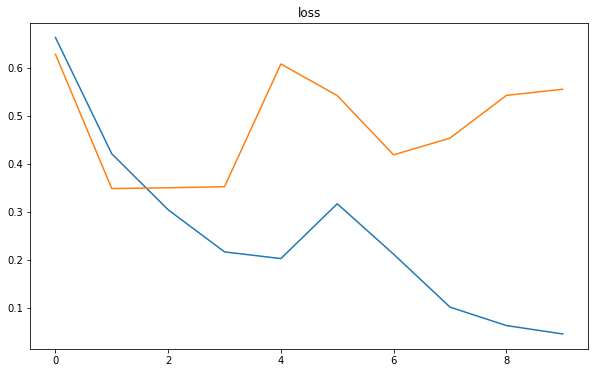

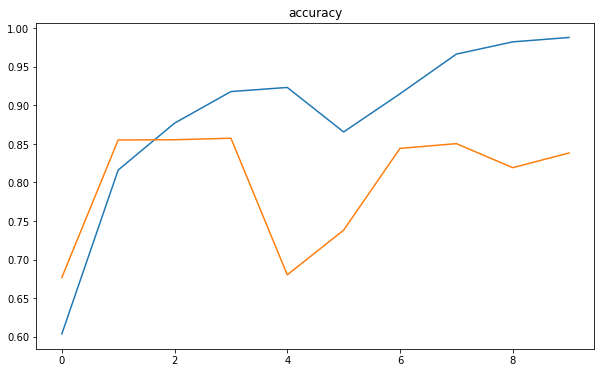

In [12]:
def plot_loss(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch, history.history['loss'])
  plt.plot(history.epoch, history.history['val_loss'])
  plt.title('loss')

def plot_accuracy(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch, history.history['accuracy'])
  plt.plot(history.epoch, history.history['val_accuracy'])
  plt.title('accuracy')

plot_loss(history)

plot_accuracy(history)

scores = model.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

## Exercise 4.2: LSTM and GRU
**[TO COMPLETE]**: In this Exercise, you have to implement 2 models, similar to the previous one that, instead of exploiting the RNN layer, use an LSTM and a GRU Layer respectively. For each model print the summary. Then, train it and plot the values of accuracy and loss. Finally, discuss the differences in terms of performance, the number of parameters, and training time. Note that you can use a different number of units than the one used in the RNN example.

In [20]:
# LSTM - complete with model definition, summary, fit and plots.

model = keras.models.Sequential()
model.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
model.add(keras.layers.LSTM(32))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer="adam", metrics=["accuracy"])

In [21]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 10)          100000    
                                                                 
 lstm_1 (LSTM)               (None, 32)                5504      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 105,537
Trainable params: 105,537
Non-trainable params: 0
_________________________________________________________________


In [22]:
history = model.fit(X_train_trim, y_train, epochs=10, batch_size=128, validation_data=(X_valid_trim, y_valid))

Epoch 1/10
196/196 [==============================] - 7s 24ms/step - loss: 0.5542 - accuracy: 0.7188 - val_loss: 0.3689 - val_accuracy: 0.8508
Epoch 2/10
196/196 [==============================] - 4s 21ms/step - loss: 0.2769 - accuracy: 0.8910 - val_loss: 0.2969 - val_accuracy: 0.8790
Epoch 3/10
196/196 [==============================] - 5s 24ms/step - loss: 0.2144 - accuracy: 0.9218 - val_loss: 0.3111 - val_accuracy: 0.8818
Epoch 4/10
196/196 [==============================] - 4s 21ms/step - loss: 0.1660 - accuracy: 0.9416 - val_loss: 0.3113 - val_accuracy: 0.8781
Epoch 5/10
196/196 [==============================] - 4s 21ms/step - loss: 0.1373 - accuracy: 0.9532 - val_loss: 0.3441 - val_accuracy: 0.8639
Epoch 6/10
196/196 [==============================] - 5s 24ms/step - loss: 0.1307 - accuracy: 0.9564 - val_loss: 0.3585 - val_accuracy: 0.8671
Epoch 7/10
196/196 [==============================] - 4s 21ms/step - loss: 0.0981 - accuracy: 0.9678 - val_loss: 0.4187 - val_accuracy: 0.8646

391/391 - 3s - loss: 0.3657 - accuracy: 0.8633 - 3s/epoch - 7ms/step
accuracy: 86.33%


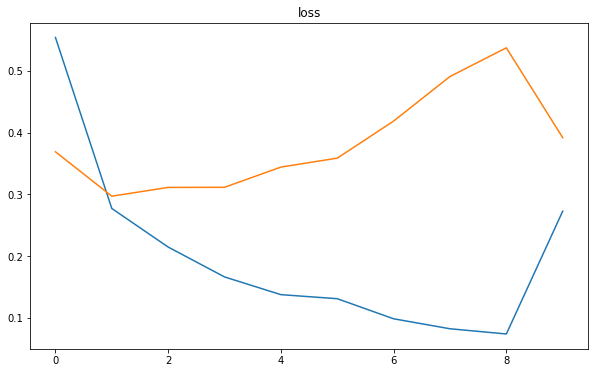

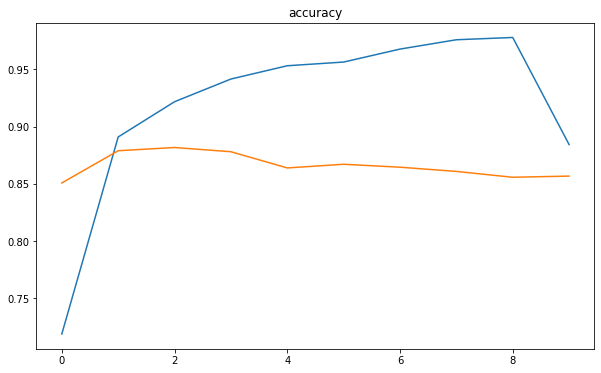

In [23]:
plot_loss(history)

plot_accuracy(history)

scores = model.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

In [24]:
# GRU - complete with model definition, summary, fit and plots.

model = keras.models.Sequential()
model.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
model.add(keras.layers.GRU(32))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer="adam", metrics=["accuracy"])

In [25]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, None, 10)          100000    
                                                                 
 gru_1 (GRU)                 (None, 32)                4224      
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 104,257
Trainable params: 104,257
Non-trainable params: 0
_________________________________________________________________


In [26]:
history = model.fit(X_train_trim, y_train, epochs=10, batch_size=128, validation_data=(X_valid_trim, y_valid))

Epoch 1/10
196/196 [==============================] - 7s 28ms/step - loss: 0.5194 - accuracy: 0.7200 - val_loss: 0.3537 - val_accuracy: 0.8448
Epoch 2/10
196/196 [==============================] - 4s 21ms/step - loss: 0.2790 - accuracy: 0.8890 - val_loss: 0.3643 - val_accuracy: 0.8413
Epoch 3/10
196/196 [==============================] - 4s 20ms/step - loss: 0.2090 - accuracy: 0.9218 - val_loss: 0.3358 - val_accuracy: 0.8678
Epoch 4/10
196/196 [==============================] - 4s 20ms/step - loss: 0.1721 - accuracy: 0.9382 - val_loss: 0.3360 - val_accuracy: 0.8674
Epoch 5/10
196/196 [==============================] - 4s 21ms/step - loss: 0.1405 - accuracy: 0.9514 - val_loss: 0.3684 - val_accuracy: 0.8616
Epoch 6/10
196/196 [==============================] - 4s 21ms/step - loss: 0.1228 - accuracy: 0.9593 - val_loss: 0.4011 - val_accuracy: 0.8602
Epoch 7/10
196/196 [==============================] - 4s 21ms/step - loss: 0.1111 - accuracy: 0.9637 - val_loss: 0.4325 - val_accuracy: 0.8547

391/391 - 3s - loss: 0.4669 - accuracy: 0.8523 - 3s/epoch - 7ms/step
accuracy: 85.23%


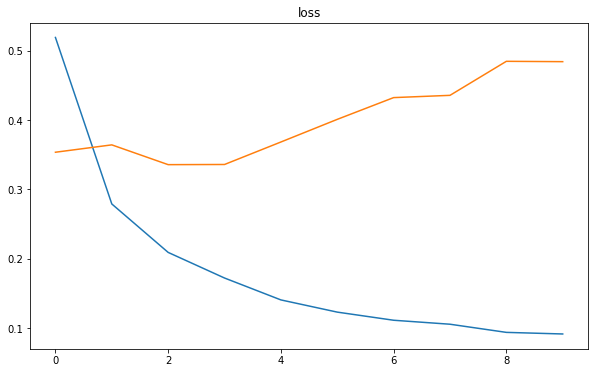

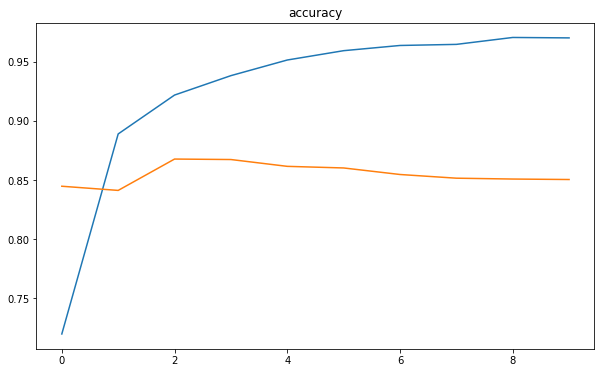

In [27]:
plot_loss(history)

plot_accuracy(history)

scores = model.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

Here I discuss the differences in terms of performance, number of parameters, and training time:

**Performance:**
* *SimpleRNN*: loss: 0.5351, accuracy: 84.39%
* *LSTM*: loss: 0.3657, accuracy: 86.33%
* *GRU*: loss: 0.4689, accuracy: 85.23%

LSTM and GRU models achieved better accuracy compared to the SimpleRNN. This improvement in performances should be related to the fact that LSTM and GRU are extension of RNN that can deal with long-term temporal dependences, making tham capable to cope with the vanishing gradient problem.

GRU perform slightly worse than LSTM, and that make sense since GRU units can be seen as a simplified version of the LSTM (they have fewer parameters).

**Parameters:**

Here I report just the number of parameter of the layer that caracterise the network:
* *SimpleRNN*: 1376
* *LSTM*: 5504
* *GRU*: 4224

I choose to use the same number of units used in the SimpleRNN model (32 units) in the other two models. Since they use more complex units, this lead to a significant increase in term of parameters.

**Training Time:**

Training times presented an unexpected behaviour, probably due to the GPU runtime.
LSTM and GRU epochs required slightly less than 5 seconds on average, while SimpleRNN (the simpler model) epochs required on average 90 seconds.
I tried to run a copy of this notebook without using a GPU runtime and this lead to a significant improvement on the training time of the SimpleRNN model (epochs required around 30 seconds).

The possible explanation of this behaviour from my point of view could be that SimpleRNN is not optimized to run on a GPU runtime.

**[TO COMPLETE]**: In order to perform a fair comparison (definition of fair: models have to use more or less the same number of parameters) between the given RNN model and the other 2 models (LSTM and GRU), how many units do they have to use?

**Insert cells (code and text) with results and discussion immediately after this cell** 



In [29]:
# Fair LSTM -> 14 units

model = keras.models.Sequential()
model.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
model.add(keras.layers.LSTM(14))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer="adam", metrics=["accuracy"])

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, None, 10)          100000    
                                                                 
 lstm_3 (LSTM)               (None, 14)                1400      
                                                                 
 dense_6 (Dense)             (None, 1)                 15        
                                                                 
Total params: 101,415
Trainable params: 101,415
Non-trainable params: 0
_________________________________________________________________


In [30]:
history = model.fit(X_train_trim, y_train, epochs=10, batch_size=128, validation_data=(X_valid_trim, y_valid))

Epoch 1/10
196/196 [==============================] - 6s 23ms/step - loss: 0.5379 - accuracy: 0.7155 - val_loss: 0.3519 - val_accuracy: 0.8582
Epoch 2/10
196/196 [==============================] - 4s 21ms/step - loss: 0.2764 - accuracy: 0.8957 - val_loss: 0.3053 - val_accuracy: 0.8728
Epoch 3/10
196/196 [==============================] - 4s 20ms/step - loss: 0.2040 - accuracy: 0.9266 - val_loss: 0.3058 - val_accuracy: 0.8810
Epoch 4/10
196/196 [==============================] - 4s 21ms/step - loss: 0.1640 - accuracy: 0.9446 - val_loss: 0.3111 - val_accuracy: 0.8734
Epoch 5/10
196/196 [==============================] - 4s 20ms/step - loss: 0.1366 - accuracy: 0.9552 - val_loss: 0.3668 - val_accuracy: 0.8671
Epoch 6/10
196/196 [==============================] - 4s 20ms/step - loss: 0.1137 - accuracy: 0.9642 - val_loss: 0.4522 - val_accuracy: 0.8564
Epoch 7/10
196/196 [==============================] - 4s 21ms/step - loss: 0.1064 - accuracy: 0.9672 - val_loss: 0.4454 - val_accuracy: 0.8593

391/391 - 3s - loss: 0.4310 - accuracy: 0.8647 - 3s/epoch - 7ms/step
accuracy: 86.47%


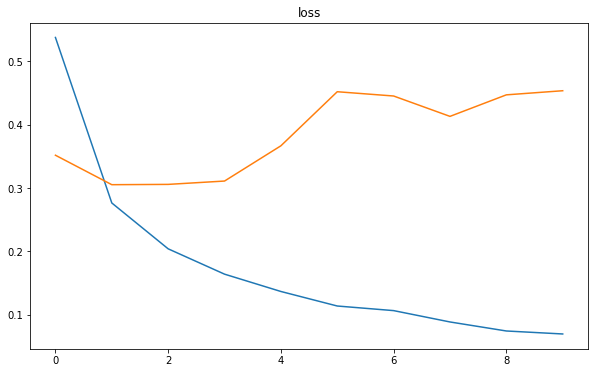

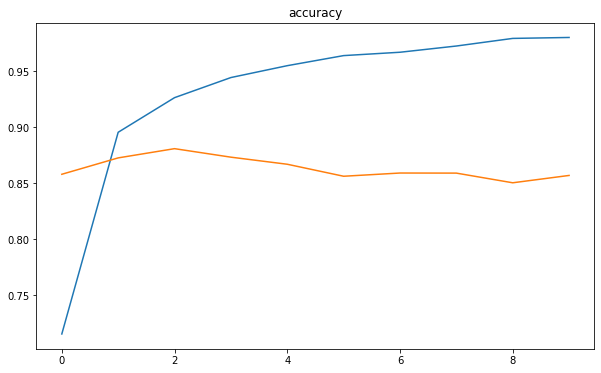

In [31]:
plot_loss(history)

plot_accuracy(history)

scores = model.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

In [32]:
# Fair GRU -> 16 units

model = keras.models.Sequential()
model.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
model.add(keras.layers.GRU(16))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer="adam", metrics=["accuracy"])

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, None, 10)          100000    
                                                                 
 gru_2 (GRU)                 (None, 16)                1344      
                                                                 
 dense_7 (Dense)             (None, 1)                 17        
                                                                 
Total params: 101,361
Trainable params: 101,361
Non-trainable params: 0
_________________________________________________________________


In [33]:
history = model.fit(X_train_trim, y_train, epochs=10, batch_size=128, validation_data=(X_valid_trim, y_valid))

Epoch 1/10
196/196 [==============================] - 7s 26ms/step - loss: 0.5584 - accuracy: 0.6958 - val_loss: 0.3758 - val_accuracy: 0.8368
Epoch 2/10
196/196 [==============================] - 5s 23ms/step - loss: 0.2967 - accuracy: 0.8821 - val_loss: 0.3173 - val_accuracy: 0.8696
Epoch 3/10
196/196 [==============================] - 4s 21ms/step - loss: 0.2228 - accuracy: 0.9179 - val_loss: 0.3296 - val_accuracy: 0.8698
Epoch 4/10
196/196 [==============================] - 4s 21ms/step - loss: 0.1855 - accuracy: 0.9348 - val_loss: 0.3610 - val_accuracy: 0.8563
Epoch 5/10
196/196 [==============================] - 4s 20ms/step - loss: 0.1578 - accuracy: 0.9466 - val_loss: 0.3629 - val_accuracy: 0.8645
Epoch 6/10
196/196 [==============================] - 4s 21ms/step - loss: 0.1384 - accuracy: 0.9547 - val_loss: 0.4034 - val_accuracy: 0.8614
Epoch 7/10
196/196 [==============================] - 4s 21ms/step - loss: 0.1220 - accuracy: 0.9615 - val_loss: 0.4143 - val_accuracy: 0.8574

391/391 - 3s - loss: 0.4476 - accuracy: 0.8547 - 3s/epoch - 7ms/step
accuracy: 85.47%


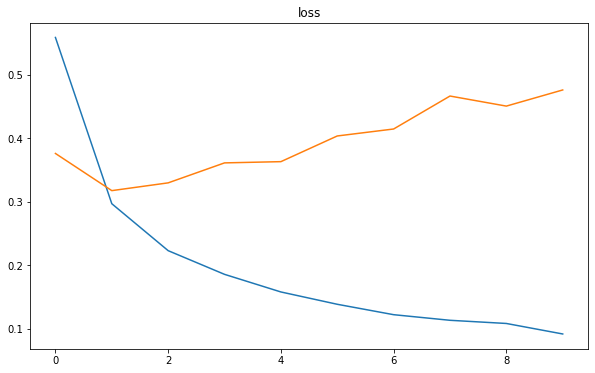

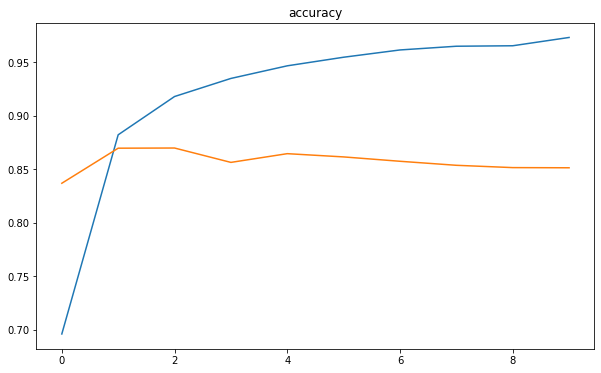

In [34]:
plot_loss(history)

plot_accuracy(history)

scores = model.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

**Answer:**

In order to perform a fair comparison with the given RNN model I used:

* 14 units for the LSTM
* 16 units for the GRU

Those were the best configuration that I was able to find in order to ensure a comparable number of parameters.
This means that the hidden layers of the 3 network have the following number of parameters:
* SimpleRNN: 1376 parameters
* LSTM: 1400 parameters
* GRU: 1344 parameters

**Performance:**
* *SimpleRNN*: loss: 0.5351, accuracy: 84.39%
* *LSTM*: loss: 0.4310, accuracy: 86.47%
* *GRU*: loss: 0.4476, accuracy: 85.47%

The performances of those two models are still better than the performance of the SimpleRNN model. By comparing them with the versions that I presented in the previous point (where I used for both of them 32 units) we can see that the reductions of units brings a (very) slight improvement in the accurancy.

This means that the large number of units used in the previous point (32) where not actually useful, and instead caused a slight decrease in performances.

### Bidirectional LSTM
In conclusion, let's also have a look at the performances of a bidirectional LSTM instead of a simple LSTM. In Keras, it is possible to define a bidirectional layer by using [tf.keras.layers.Bidirectional](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional). Note that this wrapper requires as argument a layer, in our case we use [tf.keras.layers.LSTM](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM)


In [35]:
model_bidirectional = keras.models.Sequential()
model_bidirectional.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
model_bidirectional.add(keras.layers.Bidirectional(keras.layers.LSTM(32)))
model_bidirectional.add(keras.layers.Dense(1, activation="sigmoid"))

model_bidirectional.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

model_bidirectional.summary()

history = model_bidirectional.fit(X_train_trim, y_train,
                    epochs=5, batch_size=128, validation_data=(X_valid_trim, y_valid))

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, None, 10)          100000    
                                                                 
 bidirectional (Bidirectiona  (None, 64)               11008     
 l)                                                              
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 111,073
Trainable params: 111,073
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
196/196 [==============================] - 11s 42ms/step - loss: 0.5985 - accuracy: 0.6840 - val_loss: 0.4196 - val_accuracy: 0.8319
Epoch 2/5
196/196 [==============================] - 8s 38ms/step - loss: 0.3110 - accuracy: 0.8763 - v

391/391 - 5s - loss: 0.3128 - accuracy: 0.8772 - 5s/epoch - 12ms/step
accuracy: 87.72%


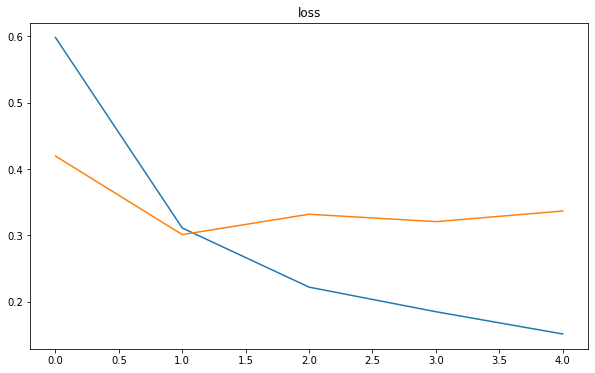

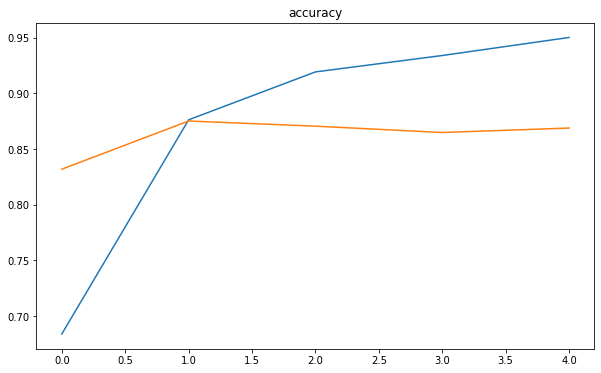

In [36]:
plot_loss(history)

plot_accuracy(history)

scores = model_bidirectional.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model_bidirectional.metrics_names[1], scores[1]*100))

## Exercise 4.3: Transformer

Let's now use a [Transformer](https://arxiv.org/abs/1706.03762) to perform the same task considered in the previous exercise. To define the Transformer we will define a class that inherits from [tensorflow.keras.layers.Layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Layer). This class represents a layer, that is a callable object that takes as input one or more tensors and that outputs one or more tensors. It involves computation, defined in the `call()` method, and a state (weight variables), both defined in the constructor. In the following cell, we will override these two methods in order to define the TransformerLayer. 

The structure of the transformer is defined as follows:
*   A multi-head attention layer, defined using the [tensorflow.keras.layers.MultiHeadAttention](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MultiHeadAttention)
*   Dropout operation (*dropout_att*)
*   Layer Normalization (*layernorm_att*)
*   A feedforward Neural Network, defenid by using keras.Sequential, and Dense layer
*   Dropout operation (*dropout_fnn*)
*   Layer Normalization (*layernorm_fnn*) that has in input the summation of the attention layer output and the feedforward NN output



In [37]:
from tensorflow.keras import layers

class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_att = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm_fnn = layers.LayerNormalization(epsilon=1e-6)
        self.dropout_att = layers.Dropout(rate)
        self.dropout_fnn = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout_att(attn_output, training=training)
        out1 = self.layernorm_att(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout_fnn(ffn_output, training=training)
        return self.layernorm_fnn(out1 + ffn_output)

Due to memory constraints of Transformers the maxlen is reduced to 200.

In [38]:
maxlen = 200
X_train_trim = keras.preprocessing.sequence.pad_sequences(X_train, maxlen=maxlen)
X_test_trim = keras.preprocessing.sequence.pad_sequences(X_test, maxlen=maxlen)
X_valid_trim = keras.preprocessing.sequence.pad_sequences(X_valid, maxlen=maxlen)

To manage the sequential structure of the input, we need to create an embedding of the word + a positional embedding. To perform this operation, similarly to what we did for defining the Transformer layer, we define a new class that inherits from *layer.Layers*. In the unbatched (i.e. single-input) version, this class has in input the index of a word and computes 2 embeddings: the embedding of the word, and the positional embedding. Finally, the method returns the summation of these two embeddings.

In [39]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

Now we can define the Transformer model. The model is defined as follows:

*   the Input layer
*   the TokenAndPositionEmbedding layer
*   the Transformer layer
*   2 Dense layers, the second one is the output layer.


**[TO COMPLETE]** Experiment with the `embed_dim, num_heads, ff_dim` and discuss the influence of these parameters in the obtained results, considering the accuracy of the output at the time required to perform the training phase. Report the discussion in the cell at the end of the notebook.

In [80]:
embed_dim = 50  # Embedding size for each token
num_heads = 20  # Number of attention heads
ff_dim = 50  # Hidden layer size in feed forward network inside transformer

inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, num_words, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

In [81]:
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
history = model.fit(
    X_train_trim, y_train, batch_size=128, epochs=5, validation_data=(X_valid_trim, y_valid)
)

Epoch 1/5
196/196 [==============================] - 26s 124ms/step - loss: 0.4175 - accuracy: 0.7956 - val_loss: 0.3187 - val_accuracy: 0.8610
Epoch 2/5
196/196 [==============================] - 26s 134ms/step - loss: 0.2272 - accuracy: 0.9119 - val_loss: 0.3270 - val_accuracy: 0.8593
Epoch 3/5
196/196 [==============================] - 26s 133ms/step - loss: 0.1871 - accuracy: 0.9284 - val_loss: 0.3387 - val_accuracy: 0.8624
Epoch 4/5
196/196 [==============================] - 25s 127ms/step - loss: 0.1484 - accuracy: 0.9470 - val_loss: 0.4096 - val_accuracy: 0.8598
Epoch 5/5
196/196 [==============================] - 26s 131ms/step - loss: 0.1347 - accuracy: 0.9520 - val_loss: 0.4181 - val_accuracy: 0.8582


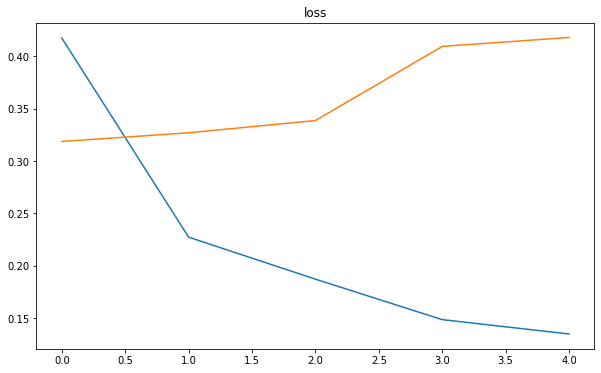

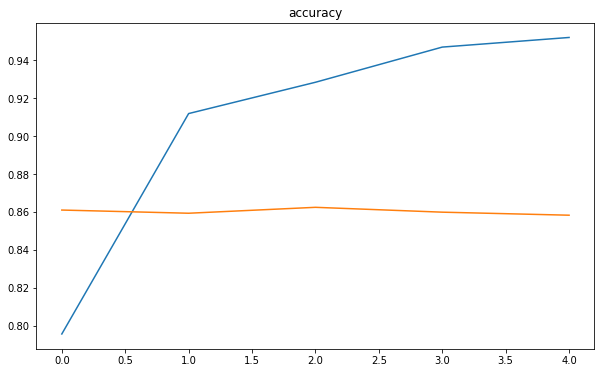

In [82]:
def plot_loss(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['loss'])
  plt.plot(history.epoch,history.history['val_loss'])
  plt.title('loss')

def plot_accuracy(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['accuracy'])
  plt.plot(history.epoch,history.history['val_accuracy'])
  plt.title('accuracy')

plot_loss(history)

plot_accuracy(history)

In [83]:
scores = model.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

391/391 - 4s - loss: 0.4224 - accuracy: 0.8577 - 4s/epoch - 11ms/step
accuracy: 85.77%


**Insert the discussion here**: 

* *embed_dim:* By increasing the embedding size for each token i noticed an increase in the training times and a reduction of the accurancy.

* *num_heads:* Increasing the number of attention heads yelds to an increase in the training times.

* *ff_dim:* Increasing the hidden layer size in feed forward network inside the transformer, doesn't really seem to have an impact on times, but caused a slight decreas of the accuracy. 